## Pretrained Models for Transfer Learning

Notebook inspired by [Hands-On Machine Learning with Scikit-Learn and PyTorch](https://www.oreilly.com/library/view/hands-on-machine-learning/9798341607972/).

### Setup

In [145]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

In [146]:
# load in pretrained ConvNeXt model
weights = torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1
model = torchvision.models.convnext_base(weights=weights).to(device='cuda')

In [147]:
# load in 102 category flower dataset
DefaultFlowers102 = partial(torchvision.datasets.Flowers102, root='datasets',
                            transform = weights.transforms(), download=True)

train_set = DefaultFlowers102(split='train')
test_set = DefaultFlowers102(split='test')
valid_set = DefaultFlowers102(split='val')

In [148]:
# list to store common flower names
class_names = [
    "pink primrose",
    "hard-leaved pocket orchid",
    "canterbury bells",
    "sweet pea",
    "english marigold",
    "tiger lily",
    "moon orchid",
    "bird of paradise",
    "monkshood",
    "globe thistle",
    "snapdragon",
    "colt's foot",
    "king protea",
    "spear thistle",
    "yellow iris",
    "globe-flower",
    "purple coneflower",
    "peruvian lily",
    "balloon flower",
    "giant white arum lily",
    "fire lily",
    "pincushion flower",
    "fritillary",
    "red ginger",
    "grape hyacinth",
    "corn poppy",
    "prince of wales feathers",
    "stemless gentian",
    "artichoke",
    "sweet william",
    "carnation",
    "garden phlox",
    "love in the mist",
    "mexican aster",
    "alpine sea holly",
    "ruby-lipped cattleya",
    "cape flower",
    "great masterwort",
    "siam tulip",
    "lenten rose",
    "barbeton daisy",
    "daffodil",
    "sword lily",
    "poinsettia",
    "bolero deep blue",
    "wallflower",
    "marigold",
    "buttercup",
    "oxeye daisy",
    "common dandelion",
    "petunia",
    "wild pansy",
    "primula",
    "sunflower",
    "pelargonium",
    "bishop of llandaff",
    "gaura",
    "geranium",
    "orange dahlia",
    "pink-yellow dahlia?",
    "cautleya spicata",
    "japanese anemone",
    "black-eyed susan",
    "silverbush",
    "californian poppy",
    "osteospermum",
    "spring crocus",
    "bearded iris",
    "windflower",
    "tree poppy",
    "gazania",
    "azalea",
    "water lily",
    "rose",
    "thorn apple",
    "morning glory",
    "passion flower",
    "lotus",
    "toad lily",
    "anthurium",
    "frangipani",
    "clematis",
    "hibiscus",
    "columbine",
    "desert-rose",
    "tree mallow",
    "magnolia",
    "cyclamen ",
    "watercress",
    "canna lily",
    "hippeastrum ",
    "bee balm",
    "ball moss",
    "foxglove",
    "bougainvillea",
    "camellia",
    "mallow",
    "mexican petunia",
    "bromelia",
    "blanket flower",
    "trumpet creeper",
    "blackberry lily",
]

In [149]:
# need to replace classification head for ConvNeXt
# look at submodule names to find it
[name for name, child in model.named_children()]

['features', 'avgpool', 'classifier']

In [150]:
# classification head
model.classifier

Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=1000, bias=True)
)

In [151]:
import torch.nn as nn

# change num of outputs
n_classes = 102

model.classifier[2] = nn.Linear(1024,
                                out_features=n_classes).to(device='cuda')

In [152]:
# freeze weights of pretrained layers; only unfreeze head
for param in model.parameters():
  param.requires_grad = False

for param in model.classifier.parameters():
  param.requires_grad = True

### Data Augmentation

In [153]:
# perform data augmentation to get better performance
import torchvision.transforms.v2 as T

eval_tfms = weights.transforms()

train_tfms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=30),
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set.transform = train_tfms
valid_set.transform = eval_tfms
test_set.transform = eval_tfms

### Train Model, Eval, Plot Setup

In [154]:
def train_epoch(model, loader, loss_fn, optimizer, device, scheduler, epoch):
  # set model to train mode
  model.train()

  # running totals
  total_loss = 0.0
  total_correct = 0
  total_n = 0
  steps = len(loader)

  for i, (X, y) in enumerate(loader):
    # load in batch
    X = X.to(device)
    y = y.to(device)

    # zero gradients
    optimizer.zero_grad()

    # get model logits and calc loss
    logits = model(X)
    loss = loss_fn(logits, y)

    # backpropogate and update optimizer
    loss.backward()
    optimizer.step()

    scheduler.step((epoch - 1) + (i + 1) / steps)

    # batch size + calc total loss and total size
    bs = y.size(0)
    total_loss += loss.item() * bs
    total_correct += (logits.argmax(dim=1) == y).sum().item()
    total_n += bs

  return total_loss / total_n, total_correct / total_n

In [155]:
def eval_epoch(model, loader, loss_fn, device):
  # set model in eval mode
  model.eval()

  # running totals
  total_loss = 0.0
  total_correct = 0
  total_n = 0

  # turn off gradient updates
  with torch.no_grad():
    for X, y in loader:
        # load in data
        X = X.to(device)
        y = y.to(device)

        # get logits + loss
        logits = model(X)
        loss = loss_fn(logits, y)

        # calc totals
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_n += bs

  return total_loss / total_n, total_correct / total_n

In [156]:
# orchestrate function
def fit(model, train_loader, val_loader, loss_fn, optimizer, device, epochs,
        scheduler):
  # lists to store losses
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(1, epochs + 1):
    # calc train and validation losses and append
    tr_loss, tr_acc = train_epoch(model, train_loader, loss_fn, optimizer, device,
                                  scheduler, epoch)
    va_loss, va_acc = eval_epoch(model, val_loader, loss_fn, device)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    print(f"epoch {epoch}: train loss={tr_loss:.4f} val loss={va_loss:.4f}")

  epochs_axis = range(1, len(train_losses) + 1)

  plt.plot(epochs_axis, train_losses, label="train loss")
  plt.plot(epochs_axis, val_losses, label="val loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show();

  plt.plot(epochs_axis, train_accs, label="train acc")
  plt.plot(epochs_axis, val_accs, label="val acc")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.show();

  return train_losses, val_losses, train_accs, val_accs

In [157]:
# create data loaders for train, test, validation data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                          shuffle=False)

val_loader = torch.utils.data.DataLoader(valid_set, batch_size=32,
                                         shuffle=False)

In [158]:
# establish loss and optimizer and unfreeze last two layers in network
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
for p in model.features[-2:].parameters():
  p.requires_grad = True

backbone_params = []
head_params = []

for name, p in model.named_parameters():
  if not p.requires_grad:
    continue
  if name.startswith("classifier"):
    head_params.append(p)
  else:
    backbone_params.append(p)

# different learning rates; one for head, one for backbone
optimizer = torch.optim.SGD(
  [{"params": backbone_params, "lr": 0.005},
   {"params": head_params, "lr": 0.05}],
  momentum=0.9,
  weight_decay=1e-4,
  nesterov=True
)

# cosine annealing for 40 epochs; add warm restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                       T_0=40,
                                                       T_mult=2)

epoch 1: train loss=3.9572 val loss=2.3316
epoch 2: train loss=1.8355 val loss=1.6108
epoch 3: train loss=1.3026 val loss=1.4433
epoch 4: train loss=1.1701 val loss=1.3830
epoch 5: train loss=1.1051 val loss=1.3615
epoch 6: train loss=1.0478 val loss=1.3127
epoch 7: train loss=1.0260 val loss=1.3020
epoch 8: train loss=0.9981 val loss=1.2735
epoch 9: train loss=0.9906 val loss=1.2600
epoch 10: train loss=0.9808 val loss=1.2484
epoch 11: train loss=0.9724 val loss=1.2465
epoch 12: train loss=0.9601 val loss=1.2584
epoch 13: train loss=0.9544 val loss=1.2324
epoch 14: train loss=0.9516 val loss=1.2158
epoch 15: train loss=0.9420 val loss=1.2171
epoch 16: train loss=0.9367 val loss=1.2129
epoch 17: train loss=0.9337 val loss=1.1963
epoch 18: train loss=0.9250 val loss=1.2063
epoch 19: train loss=0.9287 val loss=1.2042
epoch 20: train loss=0.9151 val loss=1.1997
epoch 21: train loss=0.9229 val loss=1.1994
epoch 22: train loss=0.9227 val loss=1.1880
epoch 23: train loss=0.9154 val loss=1.18

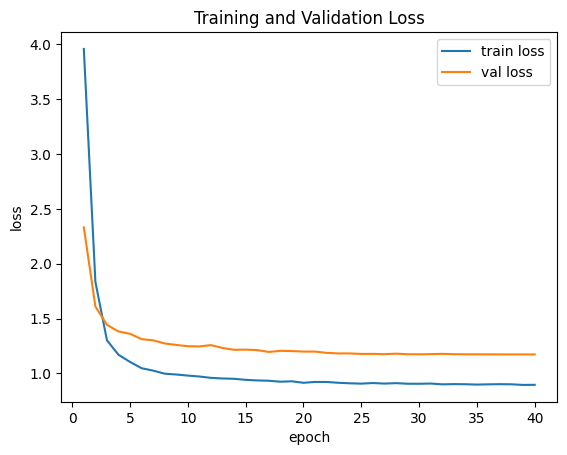

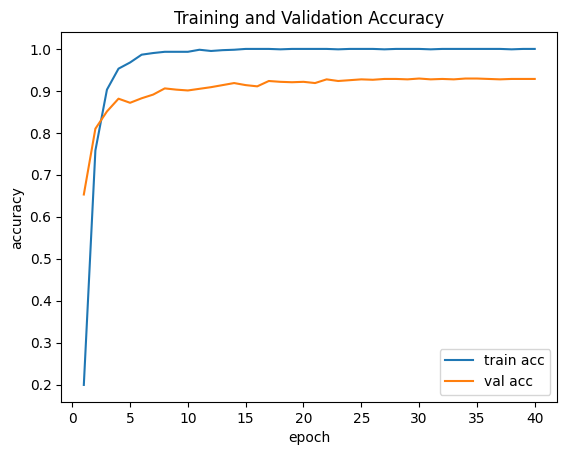

In [159]:
# set device and ensure model is on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# call orchestrator
train_losses, val_losses, train_accs, val_accs = fit(model,
                                                     train_loader,
                                                     val_loader,
                                                     criterion,
                                                     optimizer,
                                                     device,
                                                     epochs=40,
                                                     scheduler=scheduler)

In [160]:
# get evaluation value
test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Loss: 1.2255896118563896
Test Accuracy: 92.01%
